In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
# code to enable GPU support for tensorflow

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


# Creating Train, Valid, Test Folders

In [3]:
os.chdir('COVID-19_Radiography_Dataset')

In [4]:
os.getcwd()

'C:\\Users\\ledan\\Downloads\\Projects\\COVID_ML\\COVID-19_Radiography_Dataset'

In [5]:
# images/COVID has 3616 files
# images/Lung_Opacity has 6012 files
# images/Normal has 10192 files
# images/Viral_Pneumonia has 1345 files

if os.path.isdir('train/COVID') is False:
    os.makedirs('train/COVID')
    os.makedirs('train/Lung_Opacity')
    os.makedirs('train/Normal')
    os.makedirs('train/Viral_Pneumonia')
    os.makedirs('valid/COVID')
    os.makedirs('valid/Lung_Opacity')
    os.makedirs('valid/Normal')
    os.makedirs('valid/Viral_Pneumonia')
    os.makedirs('test/COVID')
    os.makedirs('test/Lung_Opacity')
    os.makedirs('test/Normal')
    os.makedirs('test/Viral_Pneumonia')
    
    for c in random.sample(glob.glob('COVID/images/COVID*'), 3000):
        shutil.copy(c, 'train/COVID')      
    for c in random.sample(glob.glob('Lung_Opacity/images/Lung_Opacity*'), 3000):
        shutil.copy(c, 'train/Lung_Opacity')
    for c in random.sample(glob.glob('Normal/images/Normal*'), 3000):
        shutil.copy(c, 'train/Normal')
    for c in random.sample(glob.glob('Viral Pneumonia/images/Viral Pneumonia*'), 1000):
        shutil.copy(c, 'train/Viral_Pneumonia')

    for c in random.sample(glob.glob('COVID/images/COVID*'), 300):
        shutil.copy(c, 'valid/COVID')        
    for c in random.sample(glob.glob('Lung_Opacity/images/Lung_Opacity*'), 300):
        shutil.copy(c, 'valid/Lung_Opacity')
    for c in random.sample(glob.glob('Normal/images/Normal*'), 300):
        shutil.copy(c, 'valid/Normal')        
    for c in random.sample(glob.glob('Viral Pneumonia/images/Viral Pneumonia*'), 200):
        shutil.copy(c, 'valid/Viral_Pneumonia')

    for c in random.sample(glob.glob('COVID/images/COVID*'), 150):
        shutil.copy(c, 'test/COVID')        
    for c in random.sample(glob.glob('Lung_Opacity/images/Lung_Opacity*'), 150):
        shutil.copy(c, 'test/Lung_Opacity')
    for c in random.sample(glob.glob('Normal/images/Normal*'), 150):
        shutil.copy(c, 'test/Normal')        
    for c in random.sample(glob.glob('Viral Pneumonia/images/Viral Pneumonia*'), 150):
        shutil.copy(c, 'test/Viral_Pneumonia')


In [6]:
train_path = 'train'
valid_path = 'valid'
test_path = 'test'

# Creating Train, Valid, Test Batches using the VGG16 preprocessing 
### Pick one of the two cells
### 1st cell is without data augmentation. 2nd cell is with data augmentation

In [7]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'], batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'], batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'], batch_size=10, shuffle=False)

Found 10000 images belonging to 4 classes.
Found 1100 images belonging to 4 classes.
Found 600 images belonging to 4 classes.


In [ ]:
train_batches = ImageDataGenerator(
rotation_range=5,  # rotational degree
width_shift_range=0.1,  # horizontal shift
zoom_range=0.1,  # zoom
brightness_range=[0.95,1.05],
horizontal_flip=True,  # horizontal flip
preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'], batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'], batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'], batch_size=10, shuffle=False)

# Checking how images look from our batches 

In [8]:
imgs, labels = next(train_batches)

# This function will plot images in the form of a grid with 1 row and 10 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img/np.amax(img))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

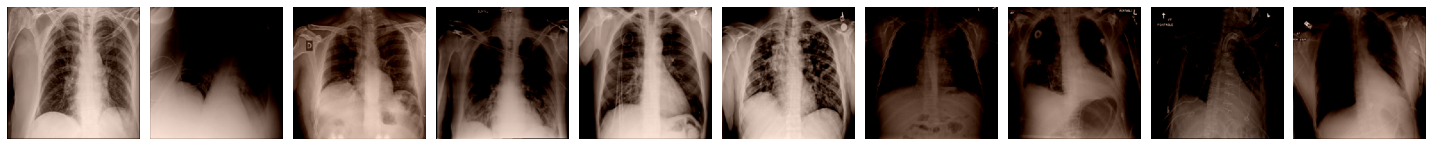

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


In [9]:
plotImages(imgs)
print(labels)

# Creating CNN Model
### Pick one of the two cells
### 1st cell is our model. 2nd cell is the official VGG16 model

In [10]:
model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
        MaxPool2D(pool_size=(2, 2), strides=2),
        keras.layers.Dropout(rate=0.2),
    
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
        MaxPool2D(pool_size=(2, 2), strides=2),
        keras.layers.Dropout(rate=0.2),
    
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
        MaxPool2D(pool_size=(2, 2), strides=2),
        keras.layers.Dropout(rate=0.2),
    
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
        MaxPool2D(pool_size=(2, 2), strides=2),
    
        Flatten(),
        Dense(units=4, activation='softmax'),
])


In [ ]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4, activation="softmax"))

# Checking and running the model

#### When running our model, use the Adam optimizer. When running the official VGG16 model, use the SGD optimizer.

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)        0

In [12]:
# use optimizer=Adam if running our model
# use optimizer=SGD if running the official VGG-16 model

model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=100,
          verbose=2,
          callbacks=[EarlyStopping(monitor='loss',min_delta=0.001,patience=3)]
)

Epoch 1/100
1000/1000 - 33s - loss: 12.2909 - accuracy: 0.5081 - val_loss: 1.0416 - val_accuracy: 0.5527 - 33s/epoch - 33ms/step
Epoch 2/100
1000/1000 - 32s - loss: 0.8762 - accuracy: 0.6330 - val_loss: 1.0426 - val_accuracy: 0.6264 - 32s/epoch - 32ms/step
Epoch 3/100
1000/1000 - 33s - loss: 0.7981 - accuracy: 0.6711 - val_loss: 0.8830 - val_accuracy: 0.6945 - 33s/epoch - 33ms/step
Epoch 4/100
1000/1000 - 34s - loss: 0.7350 - accuracy: 0.7042 - val_loss: 0.8352 - val_accuracy: 0.7000 - 34s/epoch - 34ms/step
Epoch 5/100
1000/1000 - 33s - loss: 0.6947 - accuracy: 0.7189 - val_loss: 0.7581 - val_accuracy: 0.7355 - 33s/epoch - 33ms/step
Epoch 6/100
1000/1000 - 37s - loss: 0.6486 - accuracy: 0.7440 - val_loss: 0.6751 - val_accuracy: 0.7473 - 37s/epoch - 37ms/step
Epoch 7/100
1000/1000 - 39s - loss: 0.6187 - accuracy: 0.7586 - val_loss: 0.6796 - val_accuracy: 0.7564 - 39s/epoch - 39ms/step
Epoch 8/100
1000/1000 - 33s - loss: 0.5974 - accuracy: 0.7637 - val_loss: 0.6084 - val_accuracy: 0.7845

Epoch 65/100
1000/1000 - 36s - loss: 0.1885 - accuracy: 0.9270 - val_loss: 0.2374 - val_accuracy: 0.9245 - 36s/epoch - 36ms/step
Epoch 66/100
1000/1000 - 36s - loss: 0.1933 - accuracy: 0.9290 - val_loss: 0.2660 - val_accuracy: 0.9191 - 36s/epoch - 36ms/step
Epoch 67/100
1000/1000 - 33s - loss: 0.1858 - accuracy: 0.9291 - val_loss: 0.2752 - val_accuracy: 0.9118 - 33s/epoch - 33ms/step
Epoch 68/100
1000/1000 - 34s - loss: 0.1881 - accuracy: 0.9280 - val_loss: 0.2390 - val_accuracy: 0.9245 - 34s/epoch - 34ms/step
Epoch 69/100
1000/1000 - 36s - loss: 0.1855 - accuracy: 0.9289 - val_loss: 0.2417 - val_accuracy: 0.9218 - 36s/epoch - 36ms/step
Epoch 70/100
1000/1000 - 34s - loss: 0.1815 - accuracy: 0.9316 - val_loss: 0.2651 - val_accuracy: 0.9155 - 34s/epoch - 34ms/step
Epoch 71/100
1000/1000 - 34s - loss: 0.1813 - accuracy: 0.9312 - val_loss: 0.2463 - val_accuracy: 0.9236 - 34s/epoch - 34ms/step
Epoch 72/100
1000/1000 - 33s - loss: 0.1799 - accuracy: 0.9334 - val_loss: 0.2402 - val_accuracy:

# Having the model make predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

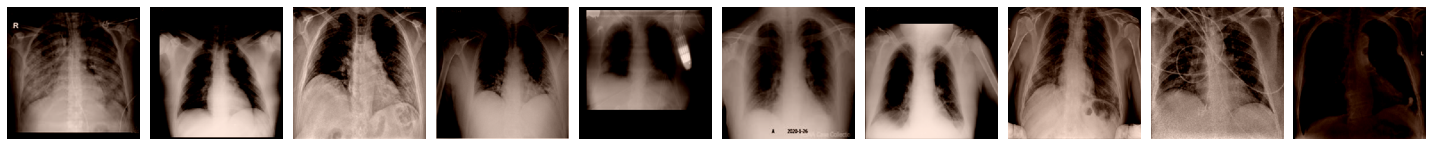

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [14]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [15]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,

In [16]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

np.round(predictions)

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

# Creating confusion matrix based off model predictions

In [17]:
# code is from scikit-learn

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    # We can apply Normalization by setting normalize=True.
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
test_batches.class_indices

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral_Pneumonia': 3}

Confusion matrix, without normalization
[[146   1   3   0]
 [  1 130  19   0]
 [  5   3 140   2]
 [  1   0   2 147]]


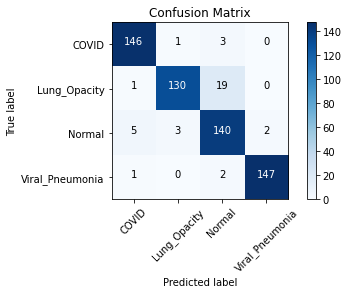

In [19]:
cm_plot_labels = ['COVID','Lung_Opacity','Normal','Viral_Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix') 

# Saving the model

In [20]:
if os.path.isfile('models/covid19_ml_model_ourModelNoAugSGD.h5') is False:
    model.save('models/covid19_ml_model_ourModelNoAugSGD.h5')

In [ ]:
model = load_model('models/covid19_ml_model_ourModelNoAugSGD.h5')

In [ ]:
model.summary()